In [40]:
import numpy as np
import matplotlib.pyplot as plt

import imagepers

from skimage.filters import threshold_otsu, median
from scipy.signal import peak_widths
# https://www.sthu.org/code/codesnippets/imagepers.html

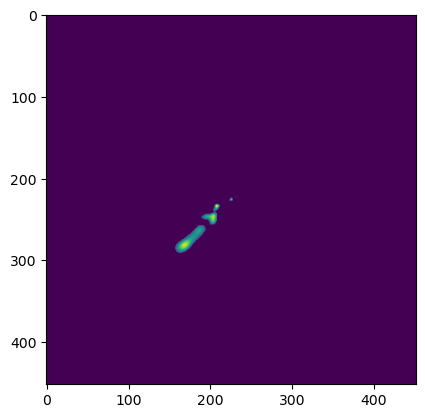

In [41]:
im = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")
im = im* (im > threshold_otsu(im))
im = median(im)
im = im * (255 / np.max(im))
plt.imshow(im)

In [42]:
g0 = imagepers.persistence(im)
g0

[((234, 208), 255.0, 255.0, None),
 ((281, 169), 238.3172799154959, 238.3172799154959, (257, 185)),
 ((226, 226), 173.39126150595996, 173.39126150595996, (231, 206)),
 ((247, 204), 227.02159712463856, 155.98925873391363, (241, 205)),
 ((264, 186), 151.46478439584635, 20.4216548011928, (270, 181)),
 ((0, 0), 0.0, 0.0, (223, 225))]

x: [208, 169, 226, 204, 186]
y: [234, 281, 226, 247, 264]


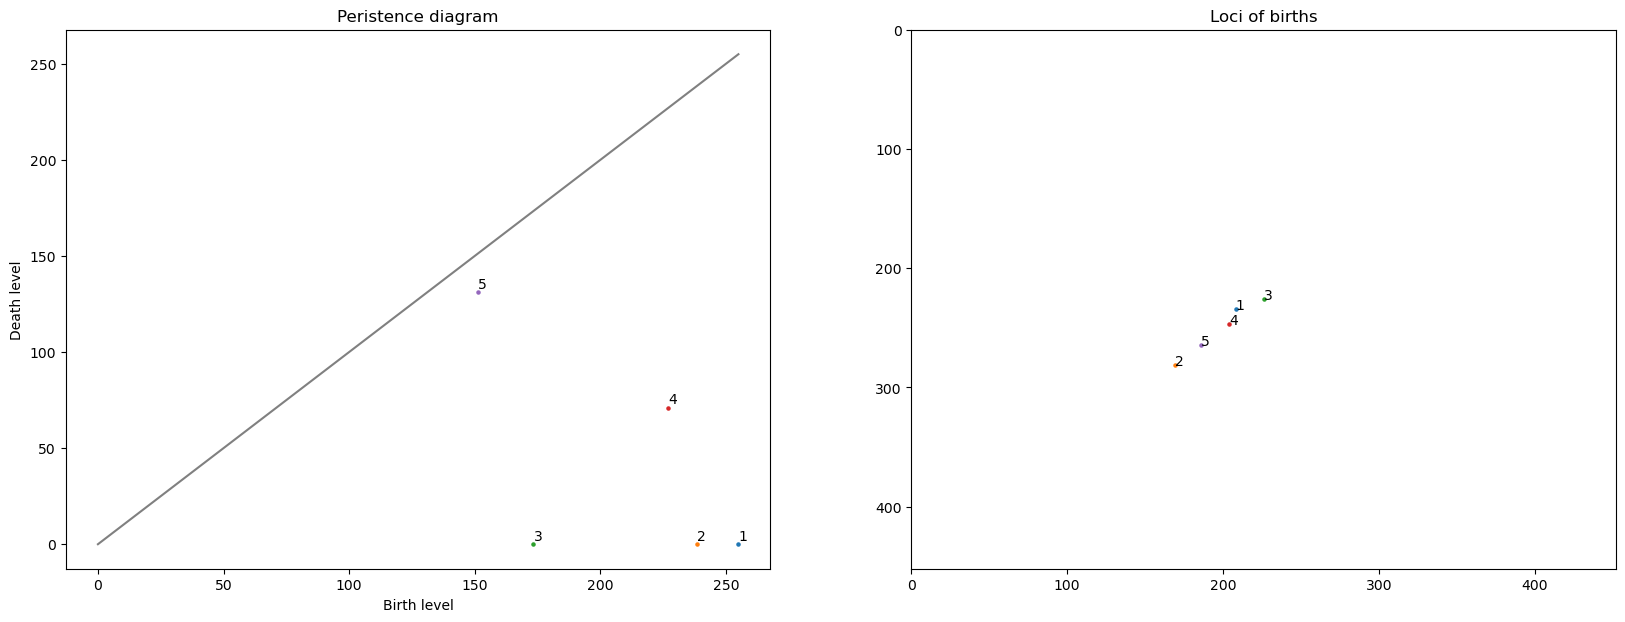

In [155]:
x_coord, y_coord = [], []

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax.set_title("Peristence diagram")
ax.plot([0,255], [0,255], c='grey')
for i, homclass in enumerate(g0):
    p_birth, bl, pers, p_death = homclass
    if pers <= 1.0:
        continue
    
    x, y = bl, bl-pers
    ax.scatter(x, y, s=5)
    ax.text(x, y+2, str(i+1))
ax.set_xlabel("Birth level")
ax.set_ylabel("Death level")
# ax.set_xlim((-5,260))
# ax.set_ylim((-5,260))


ax2.set_title("Loci of births")
for i, homclass in enumerate(g0):
    p_birth, bl, pers, p_death = homclass
    if pers <= 20.0:
        continue
    
    y, x = p_birth
    
    x_coord.append(x)
    y_coord.append(y)
    ax2.scatter(x, y, s=5)
    ax2.text(x, y+0.5, str(i+1))
    
ax2.set_xlim((0, im.shape[1]))
ax2.set_ylim((0, im.shape[0]))
ax2 = plt.gca()
plt.gca().invert_yaxis()

print('x:', x_coord)
print('y:', y_coord)

1: Vy = 0.00, Vx = 0.00, Cn2 = 1.5130282963858842e-13, z = 2020
2: Vy = -2.21, Vx = -4.98, Cn2 = 8.004430051118839e-14, z = 5051
3: Vy = -15.49, Vx = -15.76, Cn2 = 2.431426081832639e-14, z = 50000
4: Vy = -6.08, Vx = -6.08, Cn2 = 1.088787505261862e-14, z = 50000
5: Vy = -10.51, Vx = -11.06, Cn2 = 1.2977968937813254e-14, z = 39899

total Cn2: 2.7952723495853507e-13
r0: 2.74
seeing: 0.37


C:\Users\miron\AppData\Local\Temp\ipykernel_13708\2913483028.py:29: PeakPropertyWarning: some peaks have a prominence of 0
  metki = [peak_widths(gammas[i].ravel(), [np.argmax(gammas[i])], rel_height=width_value)[0] for i in range(gammas.shape[0])] # разметка
C:\Users\miron\AppData\Local\Temp\ipykernel_13708\2913483028.py:29: PeakPropertyWarning: some peaks have a width of 0
  metki = [peak_widths(gammas[i].ravel(), [np.argmax(gammas[i])], rel_height=width_value)[0] for i in range(gammas.shape[0])] # разметка


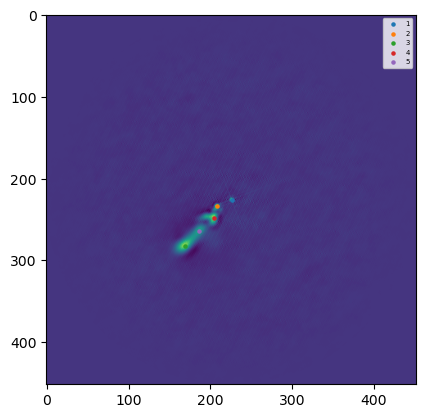

In [236]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
#     if idx == (len(array) - 1):
#         return idx, idx-1
#     if idx == 0:
#         return 1, 0
#     else:
#         if array[idx] > value:
#             return idx, idx-1 
#         if array[idx] < value:
#             return idx+1, idx

gammas = np.load("D:/astro/domecam/gammas_orig.npy")
a1 = np.loadtxt(f'D:/astro/domecam/z.gz')
cjk = np.loadtxt(f'D:/astro/domecam/cjk.gz')
im2 = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")
delta = 2.5/(im2.shape[0]//2)
t = 0.01 * 4
# -----------------------------
y=[226, 234, 282, 248, 264]
x=[226, 208, 169, 204, 186]

width_value = 0.5
converated_peaks = [(y[i] * 452) + x[i] for i in range(len(y))] # перевод найденных 2d координат пиков в 1d 
goals = peak_widths(im.ravel(), converated_peaks, rel_height=width_value)[0] # полуширина найденных пиков
metki = [peak_widths(gammas[i].ravel(), [np.argmax(gammas[i])], rel_height=width_value)[0] for i in range(gammas.shape[0])] # разметка
# заготовленной библиотеки гамм, полуширина пиков

plt.figure()
plt.imshow(im2)
total_Cn2=[]
for i in range(len(y)):
    Vy = (im2.shape[0]//2-y[i])*delta/t
    Vx = -(im2.shape[1]//2-x[i])*delta/t
    Cn2 = (im2[y[i], x[i]]/(cjk[y[i], x[i]] * np.max(gammas[find_nearest(metki, goals[i])]))) * 1e-13
    z = a1[find_nearest(metki, goals[i])] 
    total_Cn2.append(Cn2)
    plt.scatter(x[i], y[i], s=5, label=f'{i+1}')
    
    print(f'{i+1}: Vy = {Vy:.2f}, Vx = {Vx:.2f}, Cn2 = {Cn2}, z = {z:.0f}')
plt.legend(prop = { "size": 5})

total_Cn2 = np.sum(total_Cn2)
seeing_lambda = 500*10e-9
r0 = pow(0.423 * pow((2*np.pi/seeing_lambda), 2) * total_Cn2, -3/5)
seeing = 206265 * 0.98 * seeing_lambda/r0

print('\ntotal Cn2:', np.sum(total_Cn2))
print(f'r0: {r0:.2f}')
print(f'seeing: {seeing:.2f}')
# k=100
# plt.xlim(226-k,226+k)
# plt.ylim(226-k,226+k)